In [3]:
pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 MB 17.5 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 4.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import shutil
import random
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


In [2]:

# Define your dataset path
base_dir = '../../original_dataset'

# Check if the path exists
if os.path.exists(base_dir):
    print(f"The dataset path {base_dir} exists.")
else:
    print(f"The dataset path {base_dir} does not exist.")


The dataset path ../../original_dataset exists.


In [2]:

# Define your target dataset path
target_dir = '../../original_dataset'

# Check if the path exists
if os.path.exists(target_dir):
    print(f"The dataset path {target_dir} exists.")
else:
    print(f"The dataset path {target_dir} does not exist.")

The dataset path ../../original_dataset exists.


In [3]:
# Define the paths
classes = ['home_office', 'hotel_room', 'church', 'museum', 'supermarket']
# target_images_per_class = 700

# # Create target directories
# os.makedirs(target_dir, exist_ok=True)
# for cls in classes:
#     os.makedirs(os.path.join(target_dir, cls), exist_ok=True)

# # Function to copy images
# def copy_images(base_dir, target_dir, classes, num_images):
#     for cls in classes:
#         class_dir = os.path.join(base_dir, cls)
#         target_class_dir = os.path.join(target_dir, cls)
#         images = os.listdir(class_dir)
#         selected_images = random.sample(images, num_images)
#         for img in selected_images:
#             shutil.copy(os.path.join(class_dir, img), os.path.join(target_class_dir, img))
#     print("Images have been copied to the target directory.")

# # Copy 700 images from each class
# copy_images(base_dir, target_dir, classes, target_images_per_class)

In [4]:
def show_target_dir_status(target_dir, classes):
    """
    Show the number of images in each class directory within the target directory.

    """
    print(f"Status of target directory: {target_dir}")
    for cls in classes:
        class_dir = os.path.join(target_dir, cls)
        if os.path.exists(class_dir):
            num_images = len(os.listdir(class_dir))
            print(f"Class '{cls}' contains {num_images} images.")
        else:
            print(f"Class directory '{cls}' does not exist.")

# Show the status of the target directory
show_target_dir_status(target_dir, classes)

Status of target directory: ../../original_dataset
Class 'home_office' contains 1346 images.
Class 'hotel_room' contains 1524 images.
Class 'church' contains 798 images.
Class 'museum' contains 761 images.
Class 'supermarket' contains 1466 images.


In [8]:
# # Define transformations
# transform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Load the dataset
# dataset = datasets.ImageFolder(target_dir, transform=transform)

# # Print the mapping of class indices to class names
# print("Class to index mapping:", dataset.class_to_idx)


Class to index mapping: {'church': 0, 'home_office': 1, 'hotel_room': 2, 'museum': 3, 'supermarket': 4}


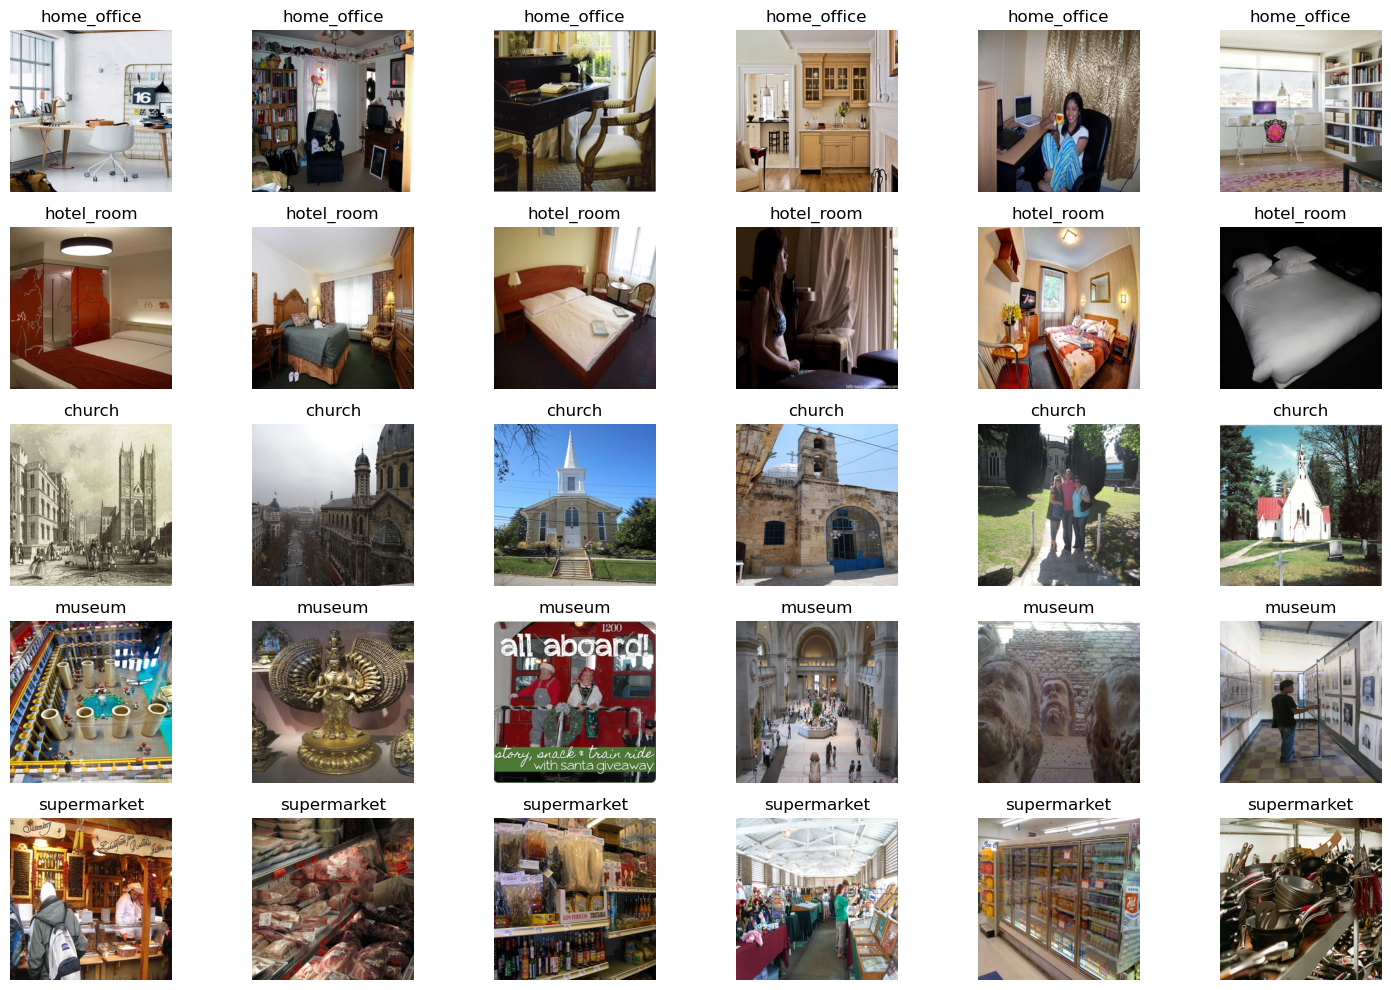

In [5]:
def show_images_with_labels(target_dir, classes, num_images=6):
    """
    Display images with their corresponding labels from the target directory.

    """
    # Create figure and axes
    fig, axes = plt.subplots(len(classes), num_images, figsize=(15, 10))
    
    # Iterate through each class
    for i, cls in enumerate(classes):
        class_dir = os.path.join(target_dir, cls)
        class_images = os.listdir(class_dir)
        selected_images = np.random.choice(class_images, num_images, replace=False)
        
        # Iterate through selected images for the class
        for j, img_name in enumerate(selected_images):
            img_path = os.path.join(class_dir, img_name)
            img = plt.imread(img_path)
            
            # Plot the image
            axes[i, j].imshow(img)
            axes[i, j].set_title(cls)
            axes[i, j].axis('off')
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

show_images_with_labels(target_dir, classes)

In [17]:
def is_image_file(filename):
    """
    Check if a file is an image based on its extension.
    """
    valid_extensions = ('.jpg', '.jpeg', '.png')
    return filename.lower().endswith(valid_extensions)

def preprocess_images(target_dir, classes, image_size=(256,256)):
    """
    Preprocess images: resize, convert to grayscale (optional), and flatten.

    Parameters:
    - target_dir (str): Path to the target directory containing class folders.
    - classes (list of str): List of class names.
    - image_size (tuple): Desired image size (width, height).

    Returns:
    - X (numpy.ndarray): Flattened image data.
    - y (numpy.ndarray): Corresponding labels.
    
    """
    X = []
    y = []
    
    for label, cls in enumerate(classes):
        class_dir = os.path.join(target_dir, cls)
        for img_name in os.listdir(class_dir):
            if is_image_file(img_name):
                img_path = os.path.join(class_dir, img_name)
                try:
                    with Image.open(img_path) as img:
                        img = img.resize(image_size)  # Resize image
                        img_array = np.array(img)  # Convert image to array
                        if img_array.shape != image_size:
                            raise ValueError(f"Image {img_path} has unexpected shape: {img_array.shape}")
                        img_array = img_array.flatten()  # Flatten the image
                        X.append(img_array)
                        y.append(label)
                except Exception as e:
                    print(f"Error processing file {img_path}: {e}")
    
    X = np.array(X)  # Convert list of arrays to numpy array
    y = np.array(y)
    return X, y
# Preprocess images
X, y = preprocess_images(target_dir, classes)
print("Image data shape:", X.shape)
print("Labels shape:", y.shape)

Error processing file ../../original_dataset/home_office/gsun_67781eb91bb386b5dc45f472fb795952.jpg: Image ../../original_dataset/home_office/gsun_67781eb91bb386b5dc45f472fb795952.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/home_office/gsun_5da5dbd628f5acb4a62dea3cebdb2948.jpg: Image ../../original_dataset/home_office/gsun_5da5dbd628f5acb4a62dea3cebdb2948.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/home_office/gsun_49f4380a859cd688b7c24d64fc4e4298.jpg: Image ../../original_dataset/home_office/gsun_49f4380a859cd688b7c24d64fc4e4298.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/home_office/gsun_6df7d143e1976f486591a408e6e0dc3f.jpg: Image ../../original_dataset/home_office/gsun_6df7d143e1976f486591a408e6e0dc3f.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/home_office/gsun_507bb47b407073150908432dac7b4478.jpg: Image ../../original_dat

Error processing file ../../original_dataset/home_office/gsun_42986b36242d4c3980acf0eb37965fcd.jpg: Image ../../original_dataset/home_office/gsun_42986b36242d4c3980acf0eb37965fcd.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/home_office/gsun_0c0e4ca5024b95f5f6ced1c7572b3ba2.jpg: Image ../../original_dataset/home_office/gsun_0c0e4ca5024b95f5f6ced1c7572b3ba2.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/home_office/gsun_bc48aac1a9333aa46f3c085ff3329e6a.jpg: Image ../../original_dataset/home_office/gsun_bc48aac1a9333aa46f3c085ff3329e6a.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/home_office/gsun_b8acd9d8e7149047af25e6730ab78b12.jpg: Image ../../original_dataset/home_office/gsun_b8acd9d8e7149047af25e6730ab78b12.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/home_office/gsun_b1bf783b1806d0112646376ad66c5db5.jpg: Image ../../original_dat

Error processing file ../../original_dataset/home_office/gsun_4961c1be596485c9b72717018143cbae.jpg: Image ../../original_dataset/home_office/gsun_4961c1be596485c9b72717018143cbae.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/home_office/gsun_819fb7f9fba62dcbf084f3c801fecf6c.jpg: Image ../../original_dataset/home_office/gsun_819fb7f9fba62dcbf084f3c801fecf6c.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/home_office/gsun_d9dace473469c89fb5a07ff8ce71664e.jpg: Image ../../original_dataset/home_office/gsun_d9dace473469c89fb5a07ff8ce71664e.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/home_office/gsun_a4e62609de1b0d47c94751953a6381fb.jpg: Image ../../original_dataset/home_office/gsun_a4e62609de1b0d47c94751953a6381fb.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/home_office/gsun_47c0ea609e210ea3791db830b3dd4251.jpg: Image ../../original_dat

Error processing file ../../original_dataset/home_office/gsun_c1a4fcbb77b814937ea3a1dca19c6932.jpg: Image ../../original_dataset/home_office/gsun_c1a4fcbb77b814937ea3a1dca19c6932.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/home_office/gsun_96f46cbc347b6fb315e1ce4cfdff55c0.jpg: Image ../../original_dataset/home_office/gsun_96f46cbc347b6fb315e1ce4cfdff55c0.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/home_office/gsun_569b4617071e171c1009bbae0e3894f7.jpg: Image ../../original_dataset/home_office/gsun_569b4617071e171c1009bbae0e3894f7.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/home_office/gsun_8cee1ebdadc45a4b4c4e260ec6bf94bd.jpg: Image ../../original_dataset/home_office/gsun_8cee1ebdadc45a4b4c4e260ec6bf94bd.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/home_office/gsun_7bcc893baf24c1011b45f5f3f929fe9b.jpg: Image ../../original_dat

Error processing file ../../original_dataset/home_office/gsun_3b2a48146abe3a7089de354c77ee1677.jpg: Image ../../original_dataset/home_office/gsun_3b2a48146abe3a7089de354c77ee1677.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/home_office/gsun_539e82095106366354c968c13d390f44.jpg: Image ../../original_dataset/home_office/gsun_539e82095106366354c968c13d390f44.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/home_office/gsun_590386e4c047b5b169f22451ebcee478.jpg: Image ../../original_dataset/home_office/gsun_590386e4c047b5b169f22451ebcee478.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/home_office/gsun_7e7994f6fdea626c41c404de852369e8.jpg: Image ../../original_dataset/home_office/gsun_7e7994f6fdea626c41c404de852369e8.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/home_office/gsun_07f4caf57f4e4c66944031b834ea3820.jpg: Image ../../original_dat

Error processing file ../../original_dataset/home_office/gsun_3ba1043e4eb140f3a4000b9d61a11209.jpg: Image ../../original_dataset/home_office/gsun_3ba1043e4eb140f3a4000b9d61a11209.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/home_office/gsun_2e8b493b651ff5c96a84c7574207a8cb.jpg: Image ../../original_dataset/home_office/gsun_2e8b493b651ff5c96a84c7574207a8cb.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/home_office/gsun_07f8cca1054f24c158752ee81b152cc5.jpg: Image ../../original_dataset/home_office/gsun_07f8cca1054f24c158752ee81b152cc5.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/home_office/gsun_d4a1cbaba10ee29abe78a9eda75a2cc3.jpg: Image ../../original_dataset/home_office/gsun_d4a1cbaba10ee29abe78a9eda75a2cc3.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/home_office/gsun_639f214354e4faedb8ebdab3555fe570.jpg: Image ../../original_dat

Error processing file ../../original_dataset/home_office/gsun_4a2a630d514586686cc4c6696f2dabd3.jpg: Image ../../original_dataset/home_office/gsun_4a2a630d514586686cc4c6696f2dabd3.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/home_office/gsun_53c4e073c1a493d8ad7df52537ceb1b7.jpg: Image ../../original_dataset/home_office/gsun_53c4e073c1a493d8ad7df52537ceb1b7.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/home_office/gsun_8a5330b9b4e796d08044dde2fcf1815a.jpg: Image ../../original_dataset/home_office/gsun_8a5330b9b4e796d08044dde2fcf1815a.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/home_office/gsun_e17eb4fc9a123535e23aabd3881989bc.jpg: Image ../../original_dataset/home_office/gsun_e17eb4fc9a123535e23aabd3881989bc.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/home_office/gsun_50c49424d91dc53548ea760d4fb175a6.jpg: Image ../../original_dat

Error processing file ../../original_dataset/hotel_room/gsun_f7565c16f50a8463d8a76664f4a73db7.jpg: Image ../../original_dataset/hotel_room/gsun_f7565c16f50a8463d8a76664f4a73db7.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/hotel_room/gsun_9e611d6189e47e29793cc62b17c5784a.jpg: Image ../../original_dataset/hotel_room/gsun_9e611d6189e47e29793cc62b17c5784a.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/hotel_room/gsun_052781217dce76c1c1050526c699d9ba.jpg: Image ../../original_dataset/hotel_room/gsun_052781217dce76c1c1050526c699d9ba.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/hotel_room/gsun_e05e44d923d2da336d58ff20d53cd569.jpg: Image ../../original_dataset/hotel_room/gsun_e05e44d923d2da336d58ff20d53cd569.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/hotel_room/gsun_12951ab6177ca51ae3d1e12d0b7c7b57.jpg: Image ../../original_dataset/hote

Error processing file ../../original_dataset/hotel_room/gsun_4b0e8e36502a03056d30678a7b84c876.jpg: Image ../../original_dataset/hotel_room/gsun_4b0e8e36502a03056d30678a7b84c876.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/hotel_room/gsun_b15fab52253ec1de168a74ee1f54b151.jpg: Image ../../original_dataset/hotel_room/gsun_b15fab52253ec1de168a74ee1f54b151.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/hotel_room/gsun_54fcdae937e092126ae59a93a0e1eee4.jpg: Image ../../original_dataset/hotel_room/gsun_54fcdae937e092126ae59a93a0e1eee4.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/hotel_room/gsun_4d14bb59492d4d1a980b6437dcfce95d.jpg: Image ../../original_dataset/hotel_room/gsun_4d14bb59492d4d1a980b6437dcfce95d.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/hotel_room/gsun_279da4015ba79bf4ee8925b0e41a715f.jpg: Image ../../original_dataset/hote

Error processing file ../../original_dataset/hotel_room/gsun_5ab4913d09e2eb02f54fdec93662cb2e.jpg: Image ../../original_dataset/hotel_room/gsun_5ab4913d09e2eb02f54fdec93662cb2e.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/hotel_room/gsun_6e3efb0824f74031e5966c80f272e2e1.jpg: Image ../../original_dataset/hotel_room/gsun_6e3efb0824f74031e5966c80f272e2e1.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/hotel_room/gsun_11eefbc4ccae9ac0c4fd4d20a3c09ddb.jpg: Image ../../original_dataset/hotel_room/gsun_11eefbc4ccae9ac0c4fd4d20a3c09ddb.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/hotel_room/gsun_60d920d398025ff23747a2896e43ca7d.jpg: Image ../../original_dataset/hotel_room/gsun_60d920d398025ff23747a2896e43ca7d.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/hotel_room/gsun_670a98bd21665ee7a4bc6beaa9bbb52f.jpg: Image ../../original_dataset/hote

Error processing file ../../original_dataset/hotel_room/gsun_079afd1b93c4f8ecd33c3f3813bca05f.jpg: Image ../../original_dataset/hotel_room/gsun_079afd1b93c4f8ecd33c3f3813bca05f.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/hotel_room/gsun_6ed5113df91e799c056c6ea843bf70a6.jpg: Image ../../original_dataset/hotel_room/gsun_6ed5113df91e799c056c6ea843bf70a6.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/hotel_room/gsun_44142610309e66cdb11a99a9a3a32a9b.jpg: Image ../../original_dataset/hotel_room/gsun_44142610309e66cdb11a99a9a3a32a9b.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/hotel_room/gsun_723a6f5da79b2abee54186e22dad5b2e.jpg: Image ../../original_dataset/hotel_room/gsun_723a6f5da79b2abee54186e22dad5b2e.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/hotel_room/gsun_768f42a5766d6613e332ce8666e59728.jpg: Image ../../original_dataset/hote

Error processing file ../../original_dataset/hotel_room/gsun_89634a6681e4d0b488fe428edfb4b330.jpg: Image ../../original_dataset/hotel_room/gsun_89634a6681e4d0b488fe428edfb4b330.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/hotel_room/gsun_cdc6270578da2572f2bfa1d85344512f.jpg: Image ../../original_dataset/hotel_room/gsun_cdc6270578da2572f2bfa1d85344512f.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/hotel_room/gsun_d3ddf0037a6245b142d9be978421ad1a.jpg: Image ../../original_dataset/hotel_room/gsun_d3ddf0037a6245b142d9be978421ad1a.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/hotel_room/gsun_0fc8baa358c3d802aa0d791450ef65b8.jpg: Image ../../original_dataset/hotel_room/gsun_0fc8baa358c3d802aa0d791450ef65b8.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/hotel_room/gsun_edf55f9b001c457f5718c0908e65d8f7.jpg: Image ../../original_dataset/hote

Error processing file ../../original_dataset/hotel_room/gsun_6c882b9695a8881bf2ee83b65ac1e5a4.jpg: Image ../../original_dataset/hotel_room/gsun_6c882b9695a8881bf2ee83b65ac1e5a4.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/hotel_room/gsun_27e47a493cb2645edf06fbdb77b8f659.jpg: Image ../../original_dataset/hotel_room/gsun_27e47a493cb2645edf06fbdb77b8f659.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/hotel_room/gsun_a2f1f95c0e3713866dc1af65d59791de.jpg: Image ../../original_dataset/hotel_room/gsun_a2f1f95c0e3713866dc1af65d59791de.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/hotel_room/gsun_503e9689210bfc84039db406ab7c3f96.jpg: Image ../../original_dataset/hotel_room/gsun_503e9689210bfc84039db406ab7c3f96.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/hotel_room/gsun_c00de38da3ccf3f35906296ef1f2aefa.jpg: Image ../../original_dataset/hote

Error processing file ../../original_dataset/hotel_room/gsun_fe43216300530193d9bd08873fffa454.jpg: Image ../../original_dataset/hotel_room/gsun_fe43216300530193d9bd08873fffa454.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/hotel_room/gsun_83f4e3d0edc03a705ea5e14cc532d3d8.jpg: Image ../../original_dataset/hotel_room/gsun_83f4e3d0edc03a705ea5e14cc532d3d8.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/hotel_room/gsun_d943d0e1feaf0cc53316d041bc6beaa1.jpg: Image ../../original_dataset/hotel_room/gsun_d943d0e1feaf0cc53316d041bc6beaa1.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/hotel_room/gsun_8fd2d0efc334fcb4916ba78b7a4fb065.jpg: Image ../../original_dataset/hotel_room/gsun_8fd2d0efc334fcb4916ba78b7a4fb065.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/hotel_room/gsun_d479cd505053c63ab6bd083e1c517719.jpg: Image ../../original_dataset/hote

Error processing file ../../original_dataset/hotel_room/gsun_f419c13b405eacc0fc2ecfd0b79660bc.jpg: Image ../../original_dataset/hotel_room/gsun_f419c13b405eacc0fc2ecfd0b79660bc.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/hotel_room/gsun_9f60c9fa20c6b9ac7aceab819e2030cf.jpg: Image ../../original_dataset/hotel_room/gsun_9f60c9fa20c6b9ac7aceab819e2030cf.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/hotel_room/gsun_aa6e2fad97873fd86053df0ec1774fae.jpg: Image ../../original_dataset/hotel_room/gsun_aa6e2fad97873fd86053df0ec1774fae.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/hotel_room/gsun_e70e505d9eb26d0cc73e4c3514d5b103.jpg: Image ../../original_dataset/hotel_room/gsun_e70e505d9eb26d0cc73e4c3514d5b103.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/hotel_room/gsun_b9dd5ae9a0e8757da810694656536fdd.jpg: Image ../../original_dataset/hote

Error processing file ../../original_dataset/church/gsun_cf08a7c14f4b7ca1088e22e34aa43692.jpg: Image ../../original_dataset/church/gsun_cf08a7c14f4b7ca1088e22e34aa43692.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/church/gsun_a8d950408a5f34444116111df889ff33.jpg: Image ../../original_dataset/church/gsun_a8d950408a5f34444116111df889ff33.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/church/gsun_406db234dab597bafc799157f4783f54.jpg: Image ../../original_dataset/church/gsun_406db234dab597bafc799157f4783f54.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/church/gsun_45bc25a6a302832aee1ef66517d1b797.jpg: Image ../../original_dataset/church/gsun_45bc25a6a302832aee1ef66517d1b797.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/church/gsun_b51447c36f2aa6869bec769435a171f4.jpg: Image ../../original_dataset/church/gsun_b51447c36f2aa6869bec769435a1

Error processing file ../../original_dataset/church/gsun_341ac3f07b3c341d1a80f807cb700bd2.jpg: Image ../../original_dataset/church/gsun_341ac3f07b3c341d1a80f807cb700bd2.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/church/gsun_68161a343abad75845188d5fa58d5440.jpg: Image ../../original_dataset/church/gsun_68161a343abad75845188d5fa58d5440.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/church/gsun_8fdee2c157bce0a42ca33479519cbebf.jpg: Image ../../original_dataset/church/gsun_8fdee2c157bce0a42ca33479519cbebf.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/church/gsun_1540c2f322403c34beaa43ea4c62cdca.jpg: Image ../../original_dataset/church/gsun_1540c2f322403c34beaa43ea4c62cdca.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/church/gsun_c04029efb406d2958904db6345b758f4.jpg: Image ../../original_dataset/church/gsun_c04029efb406d2958904db6345b7

Error processing file ../../original_dataset/church/gsun_3ebc63836437f770ee2cc364c382a870.jpg: Image ../../original_dataset/church/gsun_3ebc63836437f770ee2cc364c382a870.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/church/gsun_cf13194592ff77905655c799d97047b5.jpg: Image ../../original_dataset/church/gsun_cf13194592ff77905655c799d97047b5.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/church/gsun_1a7bf20ff493b21170c2fd84e89eb646.jpg: Image ../../original_dataset/church/gsun_1a7bf20ff493b21170c2fd84e89eb646.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/church/gsun_d20369e8327bd5ae3e984184e3dc0472.jpg: Image ../../original_dataset/church/gsun_d20369e8327bd5ae3e984184e3dc0472.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/church/gsun_47791c8f839794fc49ff7981f6345077.jpg: Image ../../original_dataset/church/gsun_47791c8f839794fc49ff7981f634

Error processing file ../../original_dataset/church/gsun_434745acc9eb0d53b8aa3321d3ce5038.jpg: Image ../../original_dataset/church/gsun_434745acc9eb0d53b8aa3321d3ce5038.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/church/gsun_29ea80eaa0630e71987bf4975f19dbad.jpg: Image ../../original_dataset/church/gsun_29ea80eaa0630e71987bf4975f19dbad.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/church/gsun_309433d896e9c938ba7490bac0a2d961.jpg: Image ../../original_dataset/church/gsun_309433d896e9c938ba7490bac0a2d961.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/church/gsun_57555adcb774298d3fa1bd7a44a4fdfc.jpg: Image ../../original_dataset/church/gsun_57555adcb774298d3fa1bd7a44a4fdfc.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/church/gsun_1ac43794643ff9bdd856706913b7e637.jpg: Image ../../original_dataset/church/gsun_1ac43794643ff9bdd856706913b7

Error processing file ../../original_dataset/museum/gsun_9da349cce7dc1dce3e55a2742336f39e.jpg: Image ../../original_dataset/museum/gsun_9da349cce7dc1dce3e55a2742336f39e.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/museum/gsun_f5b27e5fddf988f3b09a663ccde1b59f.jpg: Image ../../original_dataset/museum/gsun_f5b27e5fddf988f3b09a663ccde1b59f.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/museum/gsun_c86a589dc4f4992be05aa9ac4db13330.jpg: Image ../../original_dataset/museum/gsun_c86a589dc4f4992be05aa9ac4db13330.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/museum/gsun_c1ace899676345a6d1bdb74087703fac.jpg: Image ../../original_dataset/museum/gsun_c1ace899676345a6d1bdb74087703fac.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/museum/gsun_47af5d09e34181b29b1a5a5c3abf8662.jpg: Image ../../original_dataset/museum/gsun_47af5d09e34181b29b1a5a5c3abf

Error processing file ../../original_dataset/museum/gsun_d0af92d3a01626aa3c95b4ed921a62bd.jpg: Image ../../original_dataset/museum/gsun_d0af92d3a01626aa3c95b4ed921a62bd.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/museum/gsun_3e7c3c52b4650e4417acc880f84a5326.jpg: Image ../../original_dataset/museum/gsun_3e7c3c52b4650e4417acc880f84a5326.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/museum/gsun_b73d6c2379d5c9dc96feb826508ae42a.jpg: Image ../../original_dataset/museum/gsun_b73d6c2379d5c9dc96feb826508ae42a.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/museum/gsun_8aba2ae668148c8fe7b14d7299e8e052.jpg: Image ../../original_dataset/museum/gsun_8aba2ae668148c8fe7b14d7299e8e052.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/museum/gsun_18d735893051ea1e2ecc3b99c92a093d.jpg: Image ../../original_dataset/museum/gsun_18d735893051ea1e2ecc3b99c92a

Error processing file ../../original_dataset/museum/gsun_1dd2e87da47e359cd4fde71185aec69f.jpg: Image ../../original_dataset/museum/gsun_1dd2e87da47e359cd4fde71185aec69f.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/museum/gsun_7f641ca6a57b7c3c2a86b7ec032a2730.jpg: Image ../../original_dataset/museum/gsun_7f641ca6a57b7c3c2a86b7ec032a2730.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/museum/gsun_0ffa24b25d30327d99f5a432becd132f.jpg: Image ../../original_dataset/museum/gsun_0ffa24b25d30327d99f5a432becd132f.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/museum/gsun_2218c5e336ca3e571f2a93f086193e68.jpg: Image ../../original_dataset/museum/gsun_2218c5e336ca3e571f2a93f086193e68.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/museum/gsun_d03198cc3cc69b6886f9b76e77c9d4fa.jpg: Image ../../original_dataset/museum/gsun_d03198cc3cc69b6886f9b76e77c9

Error processing file ../../original_dataset/supermarket/gsun_88946f33ef5af56a29b5af6294bef36d.jpg: Image ../../original_dataset/supermarket/gsun_88946f33ef5af56a29b5af6294bef36d.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/supermarket/gsun_dcdbb0a31fdc64adf55330af0a026e26.jpg: Image ../../original_dataset/supermarket/gsun_dcdbb0a31fdc64adf55330af0a026e26.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/supermarket/gsun_c1ac3b9c590835d6bb0eb62003e170cc.jpg: Image ../../original_dataset/supermarket/gsun_c1ac3b9c590835d6bb0eb62003e170cc.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/supermarket/gsun_6866d5363ce8c85b7b1129e6c289d35e.jpg: Image ../../original_dataset/supermarket/gsun_6866d5363ce8c85b7b1129e6c289d35e.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/supermarket/gsun_204c1fbaca0a0515edcb49416b5713e8.jpg: Image ../../original_dat

Error processing file ../../original_dataset/supermarket/gsun_9759bc09ea6e8bfebdfc790103856e5a.jpg: Image ../../original_dataset/supermarket/gsun_9759bc09ea6e8bfebdfc790103856e5a.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/supermarket/gsun_004f336b44368df76075056a84e79be4.jpg: Image ../../original_dataset/supermarket/gsun_004f336b44368df76075056a84e79be4.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/supermarket/gsun_a86697cbdb681ce3de7b0d21f2535be1.jpg: Image ../../original_dataset/supermarket/gsun_a86697cbdb681ce3de7b0d21f2535be1.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/supermarket/gsun_972ca9334e4766e33b433a86c2fcb1df.jpg: Image ../../original_dataset/supermarket/gsun_972ca9334e4766e33b433a86c2fcb1df.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/supermarket/gsun_c39de70b1372b0f46ded6ee7bb968010.jpg: Image ../../original_dat

Error processing file ../../original_dataset/supermarket/gsun_318ed2ac0398773f5cf2e750e53f4e57.jpg: Image ../../original_dataset/supermarket/gsun_318ed2ac0398773f5cf2e750e53f4e57.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/supermarket/gsun_ed4acd497b9c50be83d547ac84d7a11b.jpg: Image ../../original_dataset/supermarket/gsun_ed4acd497b9c50be83d547ac84d7a11b.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/supermarket/gsun_823a164a8b3311e4ff41789d1815b2da.jpg: Image ../../original_dataset/supermarket/gsun_823a164a8b3311e4ff41789d1815b2da.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/supermarket/gsun_e8e687a949cd866bd827d793a58009f6.jpg: Image ../../original_dataset/supermarket/gsun_e8e687a949cd866bd827d793a58009f6.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/supermarket/gsun_c1a28c84230baa1fefeafce0aeb5216f.jpg: Image ../../original_dat

Error processing file ../../original_dataset/supermarket/gsun_f0aaa59c97e913cc127b3e5db353499d.jpg: Image ../../original_dataset/supermarket/gsun_f0aaa59c97e913cc127b3e5db353499d.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/supermarket/gsun_64cdbaaa8f9b524a7c5c865f00cfb583.jpg: Image ../../original_dataset/supermarket/gsun_64cdbaaa8f9b524a7c5c865f00cfb583.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/supermarket/gsun_08e19190c949f468ff2b0b599164fade.jpg: Image ../../original_dataset/supermarket/gsun_08e19190c949f468ff2b0b599164fade.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/supermarket/gsun_91e30a11cf14be950ac20d4fe3e3b631.jpg: Image ../../original_dataset/supermarket/gsun_91e30a11cf14be950ac20d4fe3e3b631.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/supermarket/gsun_1a031b28591322a0bd16b0ccc02d3478.jpg: Image ../../original_dat

Error processing file ../../original_dataset/supermarket/gsun_1004f7da7c70e9c9af19da313a927cf4.jpg: Image ../../original_dataset/supermarket/gsun_1004f7da7c70e9c9af19da313a927cf4.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/supermarket/gsun_7832760dee5511a5290b281752e0bce9.jpg: Image ../../original_dataset/supermarket/gsun_7832760dee5511a5290b281752e0bce9.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/supermarket/gsun_ca083a155247f14b7f4e4c68079bb1d1.jpg: Image ../../original_dataset/supermarket/gsun_ca083a155247f14b7f4e4c68079bb1d1.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/supermarket/gsun_d8d3cbc17555419785cfe199016295ee.jpg: Image ../../original_dataset/supermarket/gsun_d8d3cbc17555419785cfe199016295ee.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/supermarket/gsun_d0762fa8a59bc6527f480cf6c5113641.jpg: Image ../../original_dat

Error processing file ../../original_dataset/supermarket/gsun_da35a7f86007d03e4f6130564ee7bb7d.jpg: Image ../../original_dataset/supermarket/gsun_da35a7f86007d03e4f6130564ee7bb7d.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/supermarket/gsun_6c0463e07981afa5f92965043aab92c2.jpg: Image ../../original_dataset/supermarket/gsun_6c0463e07981afa5f92965043aab92c2.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/supermarket/gsun_815dee5aefe209a2e370c3f2508fc893.jpg: Image ../../original_dataset/supermarket/gsun_815dee5aefe209a2e370c3f2508fc893.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/supermarket/gsun_e7625c87a7396f1eb2ca8ea415e9daf8.jpg: Image ../../original_dataset/supermarket/gsun_e7625c87a7396f1eb2ca8ea415e9daf8.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/supermarket/gsun_87cb5a16628dfc688131336c72fa93f5.jpg: Image ../../original_dat

Error processing file ../../original_dataset/supermarket/gsun_68769aebf88a6495648aa8eeaadba70f.jpg: Image ../../original_dataset/supermarket/gsun_68769aebf88a6495648aa8eeaadba70f.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/supermarket/gsun_cd0a8c14621a1af8e0ca188f4966cbe0.jpg: Image ../../original_dataset/supermarket/gsun_cd0a8c14621a1af8e0ca188f4966cbe0.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/supermarket/gsun_3160c480dea6bb975e21fc32f98eb378.jpg: Image ../../original_dataset/supermarket/gsun_3160c480dea6bb975e21fc32f98eb378.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/supermarket/gsun_d4bbc4f370286420cef2e98a6e8cac22.jpg: Image ../../original_dataset/supermarket/gsun_d4bbc4f370286420cef2e98a6e8cac22.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/supermarket/gsun_92f6b75427fc25d4124eebce5709ecca.jpg: Image ../../original_dat

Error processing file ../../original_dataset/supermarket/gsun_0437ed7a2ed94fb1428b96fc5aacdc5e.jpg: Image ../../original_dataset/supermarket/gsun_0437ed7a2ed94fb1428b96fc5aacdc5e.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/supermarket/gsun_848d5462e67cda1204133013b16465fc.jpg: Image ../../original_dataset/supermarket/gsun_848d5462e67cda1204133013b16465fc.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/supermarket/gsun_e283425db96a8e4282c234f96733704d.jpg: Image ../../original_dataset/supermarket/gsun_e283425db96a8e4282c234f96733704d.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/supermarket/gsun_ea41bf6e41cb99379e39d460cb796680.jpg: Image ../../original_dataset/supermarket/gsun_ea41bf6e41cb99379e39d460cb796680.jpg has unexpected shape: (256, 256, 3)
Error processing file ../../original_dataset/supermarket/gsun_30bf152e263628e182892c02e7039985.jpg: Image ../../original_dat

In [7]:
# # Normalize features
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (4714, 196608)
Testing data shape: (1179, 196608)


In [8]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_normalized = scaler.transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [9]:
from sklearn.datasets import fetch_california_housing
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score


In [43]:
# # Define the parameter grid to tune the hyperparameters
# param_grid = {
#     'max_depth': [10, 20, 30, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Initialize and train the decision tree classifier
# dtree_reg = DecisionTreeClassifier(random_state=42)
# grid_search = GridSearchCV(estimator=dtree_reg, param_grid=param_grid, 
#                            cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
# grid_search.fit(X_train, y_train)
# best_dtree_reg = grid_search.best_estimator_ # Get the best estimator from the grid search
# y_pred = best_dtree_reg.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# rmse = mse ** 0.5
# best_params = grid_search.best_params_
# print(f"Best parameters: {best_params}")
# print(f"Test RMSE: {rmse}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2}
Test RMSE: 1.7439692002522784
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10; total time=  59.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10; total time=  55.7s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=2; total time=  54.6s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10; total time=  54.3s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5; total time=  59.7s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2; total time= 1.1min
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=2; total time=  57.1s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=10; total time=  56.2s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10; total time=  56.6s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=5; total time

[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2; total time= 1.0min
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5; total time=  53.3s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10; total time=  56.6s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2; total time= 1.1min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10; total time=  57.5s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10; total time=  58.8s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=5; total time=  57.4s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=2; total time=  58.7s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10; total time=  55.6s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10; total time=  56.7s
[CV] END max_depth=30, min_samples_leaf=4, min_samples_split=5; total time=  54.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2; total time= 1.0m

In [10]:
# Initialize and train the decision tree classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_normalized, y_train)

# Predict on the test set
y_pred = clf.predict(X_test_normalized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Supervised Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=classes))

Supervised Accuracy: 0.3443596268023749
Classification Report:
               precision    recall  f1-score   support

 home_office       0.30      0.31      0.31       269
  hotel_room       0.39      0.36      0.37       305
      church       0.46      0.49      0.47       160
      museum       0.20      0.23      0.21       152
 supermarket       0.37      0.34      0.35       293

    accuracy                           0.34      1179
   macro avg       0.34      0.35      0.34      1179
weighted avg       0.35      0.34      0.35      1179



In [11]:
model_grid = RandomForestClassifier(max_depth=20,
                                    min_samples_leaf=2,
                                    min_samples_split=2)
model_grid.fit(X_train_normalized, y_train)
y_pred_grid = model_grid.predict(X_test_normalized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_grid)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred_grid, target_names=classes))

Accuracy: 0.5368956743002544
Classification Report:
               precision    recall  f1-score   support

 home_office       0.49      0.46      0.47       269
  hotel_room       0.52      0.66      0.58       305
      church       0.75      0.65      0.70       160
      museum       0.40      0.11      0.17       152
 supermarket       0.53      0.64      0.58       293

    accuracy                           0.54      1179
   macro avg       0.54      0.50      0.50      1179
weighted avg       0.53      0.54      0.52      1179

